# Custom implementation of *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [456]:
import numpy as np
import pandas as pd
import itertools

from qiskit import Aer, transpile, QuantumRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.data_preparation import StatePreparation

import warnings
warnings.filterwarnings("ignore")

### Utils

In [457]:
def Generate_matrix(replicate_paper, matrix_dimension, eig_values_list=None):
    """
    Synthetic matrix generator through input parameters: 
        -   replicate_paper: boolean parameter, recreate 2x2 matrix used in reference paper
        -   matrix_dimension: int parameter for synthetic matrix generation
        -   eig_values_list: optional eigenvalues list. if not provided, it will be calculated from generated matrix.
    Output :
        - synthetic matrix as numpy matrix.
    """

    if replicate_paper == False:
        # Generate hermitian matrix
        random_matrix=np.random.rand(matrix_dimension, matrix_dimension) 
        hermitian_matrix=np.dot(random_matrix, random_matrix.T)

        eig, e_v = np.linalg.eig(hermitian_matrix)
        if eig_values_list is None:
            eig_values_list = np.array(eig)

        example_matrix = e_v @ np.diag(eig_values_list) @ e_v.T

    else:
        example_matrix = np.array([[1.5, 0.5],[0.5, 1.5]])
    
    normalized_example_matrix = example_matrix/np.trace(example_matrix)

    print(f'Matrix:\n {example_matrix.round(2)}\n')
    for eigenval, eigenvec in zip(np.linalg.eig(example_matrix)[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])):
        print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')
    return normalized_example_matrix

In [458]:
#computing the thetas
def thetas_computation(example_matrix, debug = False):
    """
    For a generic matrix, the corrisponding quantum state is generated through a binary tree, whose internal nodes store the amplitudes of the state. 
    The following function extract thetas,through binary tree calculation, used to construct the quantum circuit employed to encode the original information in qubits.  

    Input parameters: 
        -   example_matrix: generic matrix as numpy matrix.
    Output :
        - thetas : list of computed thetas.
        - all_combination: list combination of base state vectors.
    """
    lst_combination=[]
    
    #1 STEP: INPUT_PROBABILITIES COMPUTATION
    sum_squares = (example_matrix**2).sum()
    input_probabilities = (example_matrix**2/sum_squares).flatten()

    #2 STEP: BINARY TREE - NODES COMPUTATION
    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        if debug == True:
            print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    
    #3 STEP: BINARY TREE - THETAS COMPUTATION
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

In [459]:
def generate_qram_circuit(thetas, all_combinations, example_matrix):
    """
    For a generic matrix, the corrisponding qram circuit for matrix preprocessing into corrisponding quantum state. 

    Input parameters: 
        - example_matrix: generic matrix as numpy matrix.
        - thetas : list of computed thetas.
        - all_combination: list combination of base state vectors.
    Output :
        - qc : preprocessing circuit.
    """
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [460]:
def phase_estimation(matrix, qram_circuit, replicate_paper, eigval_list):
    """
    For a generic 2**n matrix, the corrisponding Quantum Phase Estimation for integer eigenvalues extraction 

    Input parameters: 
        - matrix: generic matrix as numpy matrix ( 2^N shape )
        - qram_circuit: preprocessing circuit
        - replicate_paper: boolean parameter, recreate 2x2 matrix used in reference paper
        - eigval_list: list of eigenvalues generated for testing purposes
    Output :
        - resolution: number of qubits used to represent the computed eigenvalues
        - pe : phase estimation circuit
    """

    if replicate_paper == True:
        resolution = 2
    else:
        # Compute how many qubits will be needed to represent the biggest eigenvalue
        # Useful for testing purposes (not general)
        resolution = int(np.ceil(np.log2(eigval_list.max()+1)))

    #Unitary Operator for PE
    u_circuit = NumPyMatrix(matrix, evolution_time=2*np.pi)

    #PE circuit
    pe = PhaseEstimation(resolution, u_circuit, name = "PE")

    num_qubit = resolution+int(np.ceil(np.log2(len(matrix)**2)))

    pe_register = QuantumRegister(num_qubit, 'total')

    pe_circuit = QuantumCircuit(pe_register)

    pe_circuit.append(qram_circuit.to_gate(), pe_register[resolution:])
    pe_circuit.append(pe.to_gate(), pe_register[0:pe.num_qubits])

    return pe_circuit, resolution

def check_statevector(backend, pe_circuit, resolution, example_matrix):
    pe_job = backend.run(transpile(pe_circuit, backend=backend))
    statevector = np.asarray(pe_job.result().get_statevector()).round(3)

    bitstrings = [''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
    statevector_dict = {}
    for bitstring, amplitude in zip(bitstrings, statevector):
        statevector_dict[bitstring] = amplitude
    return statevector_dict

In [461]:
def eigen_estimation(matrix, reconstructed_statevector, resolution, basic_print = False):
    """
    Estimate eigenvalues and eigenvectors from the input matrix and the relative output of state tomography 

    Input parameters: 
        - matrix: input matrix as numpy matrix.
        - reconstructed_statevector: the statevector obtained from tomography
        - resolution: number of qubits used to represent the computed eigenvalues
        - basic_print: boolean parameter, outputs a basic formatted print of the computed values 
    Output :
        - eigenvalues: integer eigenvalues of the input matrix
        - eigenvectors: absolute values of the eigenvectors' components
    """
        
    eigenvalues = set()

    for key in reconstructed_statevector:
        if reconstructed_statevector[key] != 0.0:
            eigenvalues.add(int(key[-resolution:][::-1], 2))

    ordered_states=[]

    for i, eig_val in enumerate(eigenvalues):
        tmp_list=[]
        for key in reconstructed_statevector:
            if int(key[-resolution:][::-1], 2) == eig_val:
                tmp_list.append(reconstructed_statevector[key])
                
        ordered_states.append(np.asarray(tmp_list))

        normalization_factor=np.sqrt((1/(sum(ordered_states[i]**2))))
        ordered_states[i]*=normalization_factor

    eigenvectors=[]

    for eig_statevector, eig_val in zip(ordered_states, eigenvalues):
        max_list=[]
        scaled_statevectors=[]
        for e, i in enumerate(range(0, len(eig_statevector), len(matrix))):
            max_list.append(max(eig_statevector[i:i+len(matrix)]))
            scaled_statevectors.append(eig_statevector[i:i+len(matrix)]/max_list[e])
        max_max=max_list[np.argmax(max_list)]
        eigenvector=scaled_statevectors[np.argmax(max_list)]*np.sqrt(max_max)
        eigenvectors.append(eigenvector)
        if basic_print == True:
            print(f'eigenvalue: {eig_val} - eigenvector: {np.real(eigenvector.round(3))}')   
    
    return eigenvalues, eigenvectors

## Main

#### Generate synthetic data

In [462]:
# Change this to false to generate a random matrix with choosen eigenvalues
replicate_paper = True
# Desired eigenvalues for the synthetic matrix
eigval_list = np.array([2, 3])
example_matrix = Generate_matrix(replicate_paper, matrix_dimension = 2, eig_values_list = eigval_list)

Matrix:
 [[1.5 0.5]
 [0.5 1.5]]

eigenvalue: 1 - eigenvector: [-0.707  0.707]
eigenvalue: 2 - eigenvector: [0.707 0.707]


as an example, we take the 2x2 matrix used in the original paper
$$
A_0=\left[\begin{array}{ll}
1.5 & 0.5 \\
0.5 & 1.5
\end{array}\right]
$$

whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

$20$ derives from $3^2 + 1^2 + 1^2 + 3^2$ and is necessary for normalization

#### Preprocessing 

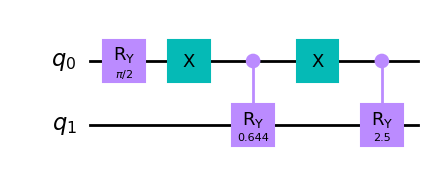

In [463]:
# Preprocessing circuit
thetas, all_combinations = thetas_computation(example_matrix, debug = False)
matrix_circuit = generate_qram_circuit(thetas, all_combinations, example_matrix)
matrix_circuit.draw("mpl")

In [464]:
#Check matrix encoding into quantum state
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'00': 0.45, '01': 0.05, '10': 0.05, '11': 0.45}

#### Phase Estimation

In [465]:
# Create and Add Phase estimation block to circuit
pe_circuit, resolution = phase_estimation(example_matrix, matrix_circuit, replicate_paper, eigval_list)

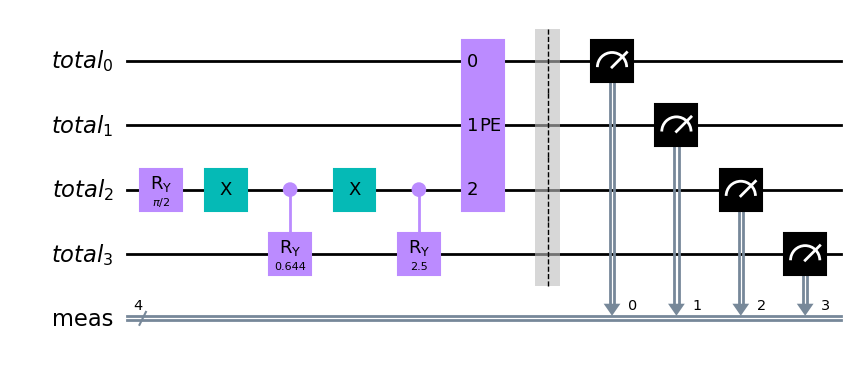

In [466]:
# Check that the circuit correctly estimates the eigenvalues 
# (only the states associated to the correct eigenvalues have probability amplitude different from 0)
# exact_statevector = check_statevector(backend,pe_circuit,resolution,example_matrix)
pe_circuit.measure_all()
# print(exact_statevector)
pe_circuit.decompose(reps=1).draw("mpl")

#### Quantum State Tomography - Probability amplitude estimation

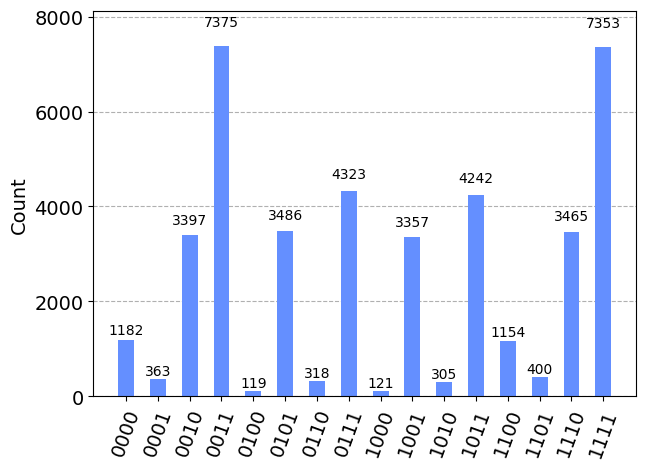

In [467]:
# Run the circuit using qiskit simulator

n_shots = 40960 # Increase to achieve higher accuracy
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(pe_circuit, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [468]:
# Reconstruct the probabilities of observing each state from the counts provided by the simulation

probabilities = {}

for i in range(2**pe_circuit.num_qubits):
    binary_i = bin(i)[2:].zfill(pe_circuit.num_qubits)
    try:
        probabilities[binary_i] = np.sqrt(counts[binary_i]/n_shots)
    except KeyError:
        probabilities[binary_i] = 0.0

probabilities # Will approximate the modulus two of the values seen in exact_statevector, two cells above

{'0000': 0.16987472406158605,
 '0001': 0.09413981457120042,
 '0010': 0.2879836285494368,
 '0011': 0.42432736293750845,
 '0100': 0.05390058847081356,
 '0101': 0.29173176356886477,
 '0110': 0.08811170112419803,
 '0111': 0.32487227057337476,
 '1000': 0.05435164728414402,
 '1001': 0.28628309033629634,
 '1010': 0.08629188294677548,
 '1011': 0.3218143146676356,
 '1100': 0.16785061252494732,
 '1101': 0.09882117688026186,
 '1110': 0.2908517260779107,
 '1111': 0.423693995192875}

In [469]:
# print("Quantum method results (only absolute values):")
# eigenvalues, eigenvectors = eigen_estimation(example_matrix, reconstructed_statevector, resolution=resolution, basic_print=True)

In [470]:
# Create the first operator for tomography
pe_circuit.remove_final_measurements()
op_U = pe_circuit.to_gate(label='op_U').control()
#Create second operator tomography
op_V = StatePreparation(list(probabilities.values()),label='c_V').control()

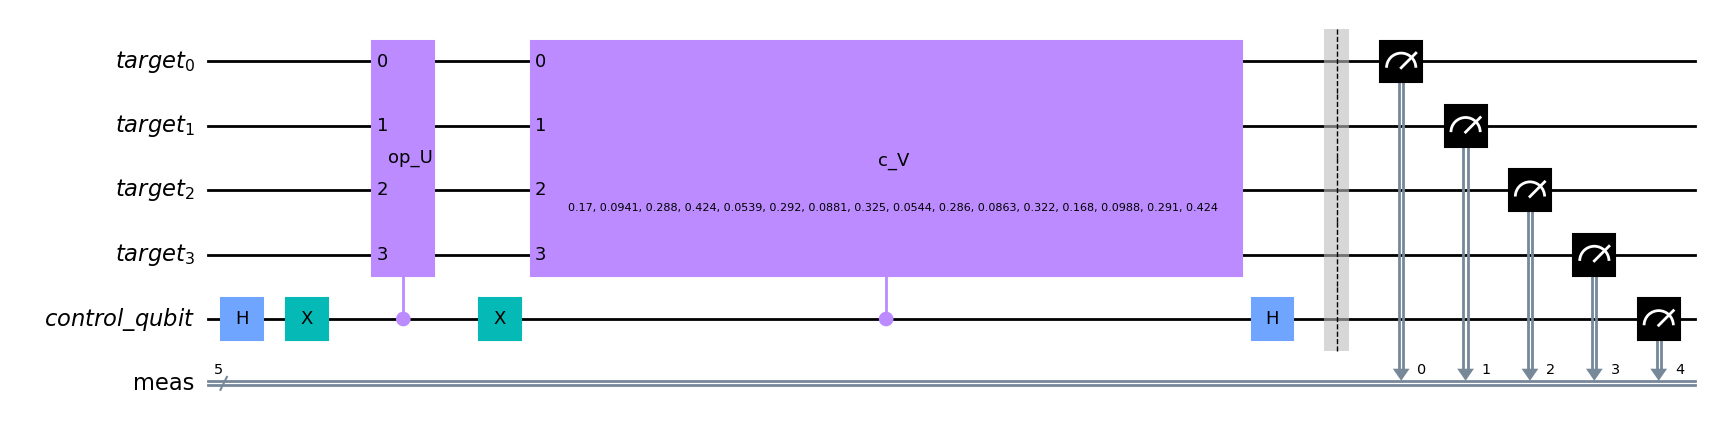

In [471]:
qr_target = QuantumRegister(pe_circuit.num_qubits, 'target')
qr_control = QuantumRegister(1, 'control_qubit')

sign_estimation_circuit = QuantumCircuit(qr_target, qr_control, name='sign_estimation')
sign_estimation_circuit.h(qr_control)
sign_estimation_circuit.x(qr_control)

sign_estimation_circuit.append(op_U, qr_control[:]+qr_target[:])
sign_estimation_circuit.x(qr_control)
sign_estimation_circuit.append(op_V, qr_control[:]+qr_target[:])
sign_estimation_circuit.h(qr_control)
sign_estimation_circuit.measure_all()
sign_estimation_circuit.draw("mpl")

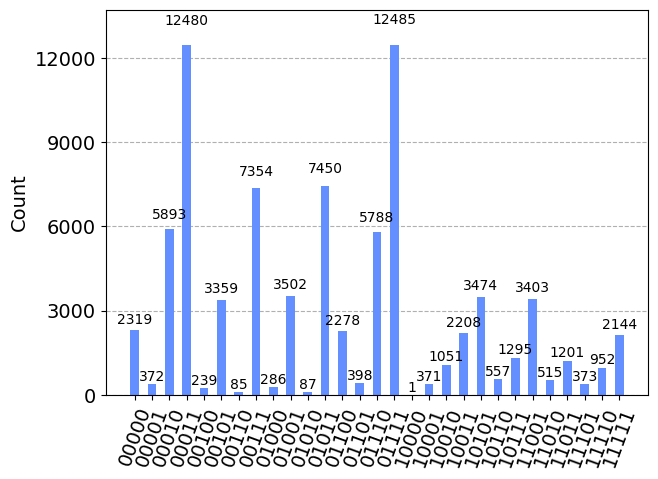

In [472]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(sign_estimation_circuit, backend=backend_total), shots=n_shots*2)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [473]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**pe_circuit.num_qubits)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]

#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, probabilities.values())):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=1
    sign_dictionary.update({bin(e)[2:].zfill(pe_circuit.num_qubits):sign})

In [474]:
df = pd.DataFrame.from_dict(probabilities, orient='index')
df.reset_index(inplace=True)
df.columns=['state', 'module']

df

,state,module
0,0000,0.169875
1,0001,0.094140
2,0010,0.287984
3,0011,0.424327
4,0100,0.053901
5,0101,0.291732
6,0110,0.088112
7,0111,0.324872
8,1000,0.054352
9,1001,0.286283


In [475]:
df['lambda']=df['state'].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1=df1.sort_values('module',ascending=False)
df1

,module
lambda,
11,1.494708
01,0.770976
10,0.753239
00,0.445978


In [476]:
df1.reset_index(inplace=True)
df1['num']=df1['lambda'].apply(lambda x :int(x[::-1],base=2)/(2**resolution))
df1

,lambda,module,num
0,11,1.494708,0.75
1,01,0.770976,0.50
2,10,0.753239,0.25
3,00,0.445978,0.00


In [477]:
peaks=[]
nums_peaks=[]
peaks.append(df1.iloc[0]['lambda'])
nums_peaks.append(df1.iloc[0]['num'])
for i in range(1,len(df1)):
    
    #for n_ in nums_peaks:
        
    if any(abs(df1.iloc[i]['num']-n_)<= 4/(2**resolution) for n_ in nums_peaks):
        #if any(abs(tail1.iloc[i]['num']-n_)/n_<= 0.2 for n_ in nums_peaks):
        pass
    else:
           
        nums_peaks.append(df1.iloc[i]['num'])
        peaks.append(df1.iloc[i]['lambda'])
        pass
    if len(peaks)==len(example_matrix):
        break
    #print(tail.iloc[i])

<AxesSubplot: xlabel='num'>

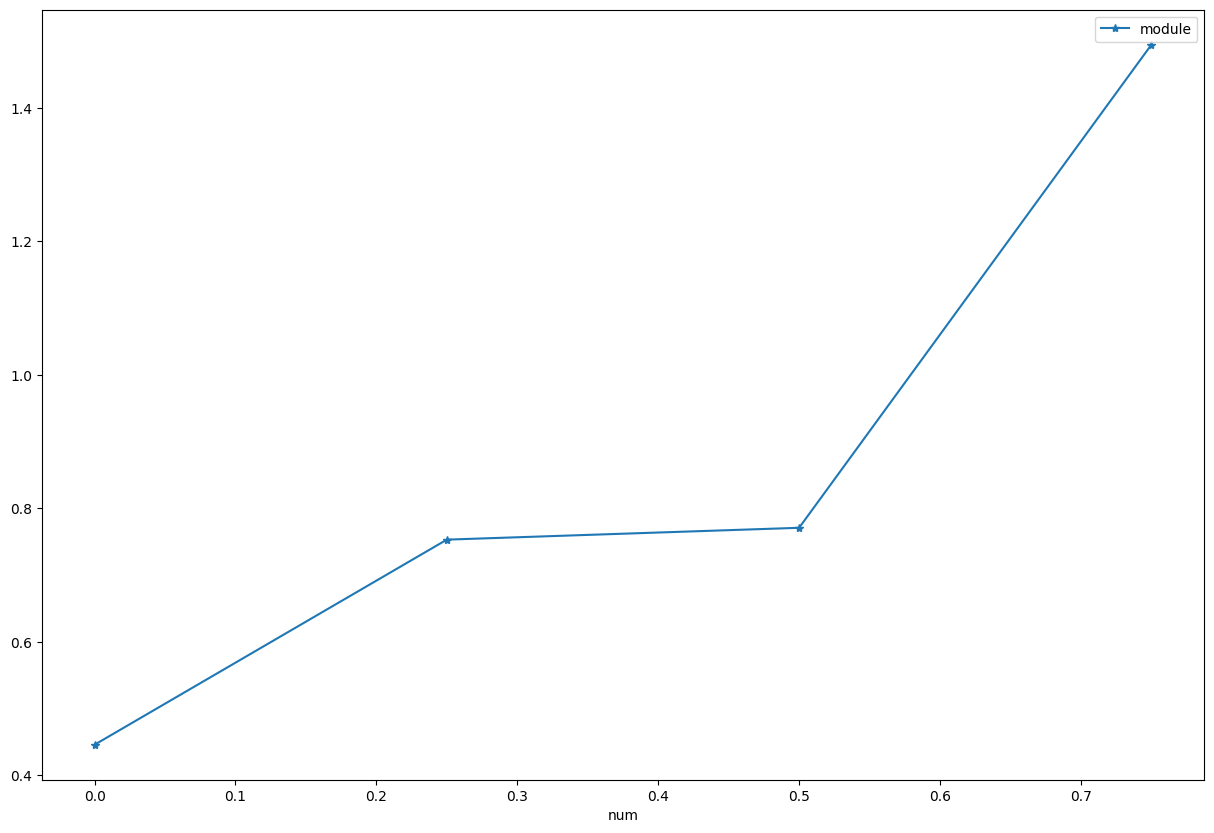

In [478]:
df1[['num','module']].sort_values('num').set_index('num').plot(style='-*',figsize=(15,10))

In [449]:
lambdas=peaks
lambdas

['10']

In [450]:
df.columns=['state','module','lambda']
df

,state,module,lambda
0,0000,0.354347,00
1,0001,0.144900,01
2,0010,0.447977,10
3,0011,0.147157,11
4,0100,0.145908,00
5,0101,0.082827,01
6,0110,0.316729,10
7,0111,0.076227,11
8,1000,0.145908,00
9,1001,0.083415,01


In [451]:
df['sign']=np.array(list(sign_dictionary.values()))
#df['sign']=np.array(sign)
df

,state,module,lambda,sign
0,0000,0.354347,00,1
1,0001,0.144900,01,-1
2,0010,0.447977,10,1
3,0011,0.147157,11,-1
4,0100,0.145908,00,-1
5,0101,0.082827,01,-1
6,0110,0.316729,10,1
7,0111,0.076227,11,-1
8,1000,0.145908,00,-1
9,1001,0.083415,01,-1


In [452]:
df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
#df['module']=df['module'].multiply(np.array(sign), axis=0)
df=df.fillna(0)
df

,state,module,lambda,sign
0,0000,0.354347,00,1
1,0001,-0.144900,01,-1
2,0010,0.447977,10,1
3,0011,-0.147157,11,-1
4,0100,-0.145908,00,-1
5,0101,-0.082827,01,-1
6,0110,0.316729,10,1
7,0111,-0.076227,11,-1
8,1000,-0.145908,00,-1
9,1001,-0.083415,01,-1


In [453]:
a=[]
save_sign=[]
eigenvalues=[]
for l in lambdas:
    eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
    a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
    #print(a_)
    save_sign.append(np.sign(a_))
    #print(save_sign)
    
    a.append(np.sqrt(abs(a_)))

#a=[a1,a2]

for i in range(len(a)):
    print(a[i])
    normalization_factor=np.sqrt((1/(sum(a[i]**2))))
    print(normalization_factor)
    a[i]*=normalization_factor
    a[i]*=save_sign[i]
    
    print(a)

[0.66931101 0.56278699 0.55985364 0.66640151]
0.8105118392105616
[array([0.5424845 , 0.45614552, 0.453768  , 0.54012632])]


In [454]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(a,eigenvalues):
    
    eigenvector=np.zeros(len(example_matrix)) #put length of eigenvector
    save_sign=np.sign(ll)
    sv=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(sv),len(example_matrix))):
        max_list.append(max(sv[i:i+len(example_matrix)]))
        scaled_statevectors.append(sv[i:i+len(example_matrix)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[len(example_matrix)*idx_max:len(example_matrix)*idx_max+len(example_matrix)]
    eigenvectors.append((eig,eigenvector))
    print('reconstructed_eigenvector:',eigenvector)
    print('reconstructed_eigenvalue:', eig*np.trace(np.array([[1.5, 0.5],[0.5, 1.5]])))
    

reconstructed_eigenvector: [0.73653547 0.61931236]
reconstructed_eigenvalue: 0.75


In [455]:
print("Classically computed values:")
zipped_list = list(zip(np.linalg.eig(example_matrix*np.trace(np.array([[1.5, 0.5],[0.5, 1.5]])))[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])))
for eigenval, eigenvec in sorted(zipped_list, key = lambda x: x[0]):
    print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')

Classically computed values:
eigenvalue: 1 - eigenvector: [-0.707  0.707]
eigenvalue: 2 - eigenvector: [0.707 0.707]
